# Analysis of the number of children in public schools German federal states

## 0. Introduction and Setup

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import school_analysis as sa
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

if not os.path.exists("../data/raw/genesis"):
    %run ../src/school_analysis/download_all.py --keep-raw
FS_PATH = "data/raw/genesis/school_children_by_state.csv"
SCHOOL_TYPE_PATH = "data/raw/genesis/school_children_by_type.csv"

## 1. Data Import and Preparation

In [14]:
from operator import index
import warnings

def load_number_childs_fs(path: str = FS_PATH) -> pd.DataFrame:
    """Load table from destatis excel file"""
    df = pd.read_csv(os.path.join(sa.PROJECT_PATH ,path), sep=";", skiprows=5, skipfooter=4, engine="python")
    df.replace("", "", inplace=True, regex=True)
    df.columns = ["School Year"] + df.columns[1:].tolist()
    df.rename(columns={"Baden-W\\xc3\\xbcrttemberg": "Baden-Württemberg"}, inplace=True)
    df.rename(columns={"Th\\xc3\\xbcringen": "Thüringen"}, inplace=True)
  
    # Generate gender column
    num_years = 26
    male = df.iloc[:num_years + 3].index
    female = df.iloc[num_years + 3:].index
    all = df.iloc[2 * num_years + 4:].index
    df["gender"] = np.nan
    df.iloc[male, -1] = "m"
    df.iloc[female, -1] = "f"
    df.iloc[all, -1] = "all"
    df.drop([1,2,29,56], inplace=True)
        
    # Build own melted table --> may be done better
    temp = pd.DataFrame(columns=["Federal State", "Gender", "Type", "Value", "Year"])
    for col_index in range(1, len(df.columns)-1, 3):
        for index in df.index[1:]:
            year = df.loc[index, "School Year"]
            gender = df.loc[index, "gender"]
            federal_state = df.columns[col_index]
            temp.loc[len(temp)] = [federal_state, gender, "Pupils", df.loc[index][df.columns[col_index]], year]
            temp.loc[len(temp)] = [federal_state, gender, "School beginners", df.loc[index][df.columns[col_index + 1]], year]
            temp.loc[len(temp)] = [federal_state, gender, "School leavers (graduates and dropouts)", df.loc[index][df.columns[col_index + 2]], year]
            
    df = temp
    df['Value'] = df['Value'].str.replace("'", '')
    df.replace(" ", np.nan, inplace=True)
    df.replace("-", np.nan, inplace=True)
    df.replace("-", np.nan, inplace=True)
    df.replace("'", "", inplace=True)
    df["Value"] = df["Value"].astype(float)
    df["Year"] = df["Year"].replace("/.*", "", regex=True).astype(int)
    df = df[df["Year"] >= 1998]
    return df

# Load the data and display 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = load_number_childs_fs()
data

,Federal State,Gender,Type,Value,Year
3,Baden-Württemberg,m,Pupils,650777.0,1998
4,Baden-Württemberg,m,School beginners,NaN,1998
5,Baden-Württemberg,m,School leavers (graduates and dropouts),58589.0,1998
6,Baden-Württemberg,m,Pupils,658612.0,1999
7,Baden-Württemberg,m,School beginners,62803.0,1999
...,...,...,...,...,...
3691,Thüringen,all,School beginners,18873.0,2020
3692,Thüringen,all,School leavers (graduates and dropouts),17523.0,2020
3693,Thüringen,all,Pupils,199328.0,2021
3694,Thüringen,all,School beginners,18759.0,2021


In [15]:
def load_number_childs_school_type(path: str = SCHOOL_TYPE_PATH):
    df = pd.read_csv(os.path.join(sa.PROJECT_PATH ,path), sep=";", skiprows=7, skipfooter=12, engine="python")
    df.replace("b'", "", inplace=True, regex=True)
    df.rename(columns={"": "School Year"}, inplace=True)
    df.rename(columns={"Baden-W\\xc3\\xbcrttemberg": "Baden-Württemberg"}, inplace=True)
    df.rename(columns={"Th\\xc3\\xbcringen": "Thüringen"}, inplace=True)
    df = df.drop([1]).reset_index(drop=True)
    
    # Set school Year
    for col_i in range(2, len(df.columns), 3):
        df.iloc[0, col_i + 1] = df.iloc[0, col_i]
        df.iloc[0, col_i + 2] = df.iloc[0, col_i]
    
    df.iloc[0, 0] = "School Type"
    df.iloc[0, 1] = "Certificate Type"
    df.columns = df.iloc[0, :]
    df = df.drop([0])
    df.loc[df[df.columns[0]] == "", [df.columns[0]]] = np.nan
    
    # Build own melted table --> may be done better
    temp = pd.DataFrame(columns=["School Type", "Certificate Type", "Gender", "Value", "Year"])
    for col_index in range(2, len(df.columns), 3):
        
        def insert_entry(i, c_i, last_school):
            year = df.columns[c_i]
            gender = df.iloc[0, c_i]
            school_type = df.iloc[i, 0]
            school_type = school_type if school_type is not np.nan else last_school
            last_school = school_type
            certificate = df.iloc[i, 1]            
            temp.loc[len(temp)] = [school_type, certificate, gender, df.iloc[i, c_i], year]
            return last_school
        
        lc = ""
        for index in range(len(df.index[1:])):
            lc = insert_entry(index, col_index, lc)
            lc = insert_entry(index, col_index+1, lc)
            lc = insert_entry(index, col_index+2, lc)

    df = temp
    df = df.drop([0])
    df = df[df["School Type"] != ""]
    df = df.replace("-", np.nan)
    df["Year"] = df["Year"].replace("/.*", "", regex=True).astype(int)
    df['Value'] = df['Value'].str.replace("'", '')
    df = df.replace("-", np.nan)
    df["Value"] = df["Value"].astype(float)
    df['Gender'] = df['Gender'].str.replace("'", '')
    return df

data_school_type = load_number_childs_school_type()
data_school_type_ger = data_school_type[data_school_type["School Type"] == "Total"]
data_school_type = data_school_type[data_school_type["School Type"] != "Total"]

# Plot the number of school children per federal state per year

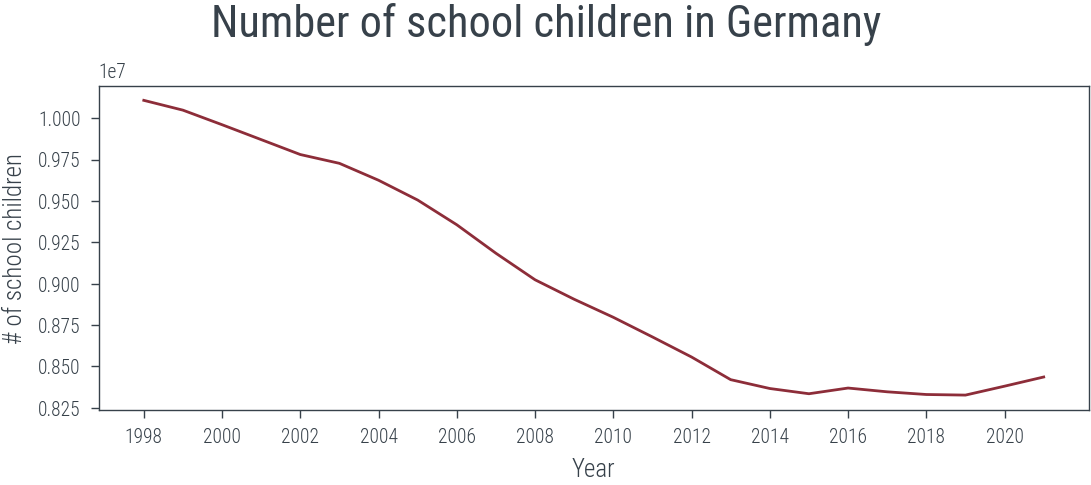

In [16]:
# Plot the data
fig, ax = plt.subplots(1, 1)


aggregated = data.groupby(["Year", "Gender", "Type"]).apply(lambda x: x["Value"].sum()).reset_index()
aggregated.rename(columns={0: "Value"}, inplace=True)

male = aggregated.loc[aggregated["Gender"] == "m"]
female = aggregated.loc[aggregated["Gender"] == "f"]
all = aggregated.loc[aggregated["Gender"] == "all"]

ax.plot(all[all["Type"] == "Pupils"]["Year"], all[all["Type"] == "Pupils"]["Value"])

ax.set_xlabel("Year")
ax.set_ylabel("# of school children")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))

# Other settings
fig.suptitle("Number of school children in Germany", fontsize=16)

plt.show()

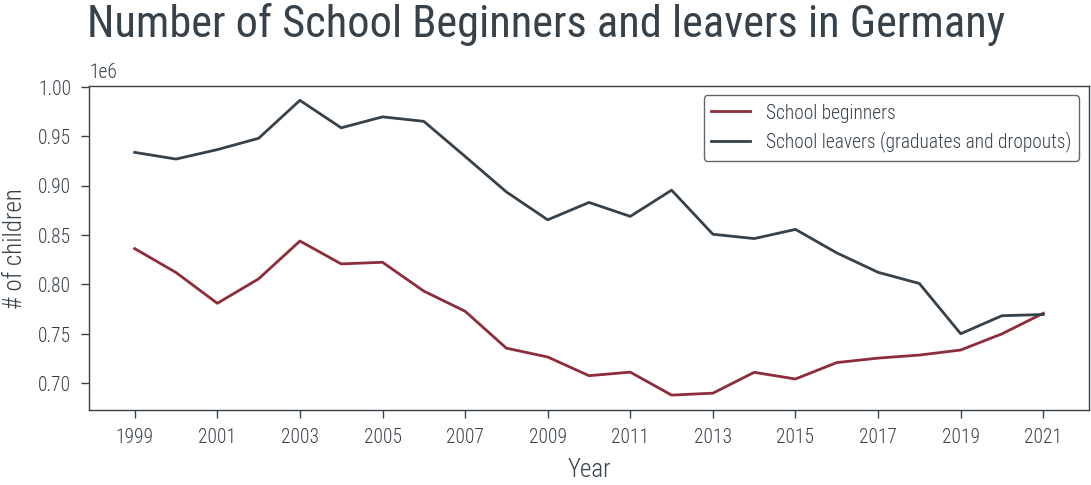

In [17]:
# Plot the data
fig, ax = plt.subplots(1, 1)


aggregated = data.groupby(["Year", "Gender", "Type"]).apply(lambda x: x["Value"].sum()).reset_index()
aggregated = aggregated[aggregated["Year"] >= 1999].loc[aggregated["Year"] <= 2021]
aggregated.rename(columns={0: "Value"}, inplace=True)

male = aggregated.loc[aggregated["Gender"] == "m"]
female = aggregated.loc[aggregated["Gender"] == "f"]
all = aggregated.loc[aggregated["Gender"] == "all"]
ax.plot(all[all["Type"] == "School beginners"]["Year"], all[all["Type"] == "School beginners"]["Value"])
ax.plot(all[all["Type"] == "School leavers (graduates and dropouts)"]["Year"], all[all["Type"] == "School leavers (graduates and dropouts)"]["Value"])


ax.set_xlabel("Year")
ax.set_ylabel("# of children")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))
ax.legend(["School beginners", "School leavers (graduates and dropouts)"])

# Other settings
fig.suptitle("Number of School Beginners and leavers in Germany", fontsize=16)

plt.show()

## Plots per school type
see <https://www.datenportal.bmbf.de/portal/en/G287.html> for school type descriptions

In [18]:
data_school_type["School Type"].value_counts()

School Type
Secondary general schools                    450
Schools with various courses of education    450
Intermediate schools                         450
Grammar schools (9 years of schooling)       450
Grammar schools (8 years of schooling)       450
Integrated comprehensive schools             450
Free Waldorf Schools                         450
Special schools                              450
Evening secondary general schools            450
Evening intermediate schools                 450
Evening grammar schools                      450
Adult education colleges                     450
Externals                                    225
Name: count, dtype: int64

In [19]:
data_school_type["Certificate Type"].value_counts()

Certificate Type
Without secondary general school certificate          975
Secondary general school certificate                  975
Intermediate school certificate                       975
Entrance qualification for univ. of appl. sciences    900
University entrance qualification                     900
Total                                                 900
Name: count, dtype: int64

In [20]:
data_school_type["Gender"].value_counts()

Gender
Male      1875
Female    1875
Total     1875
Name: count, dtype: int64

## Gymnasium G8/G9

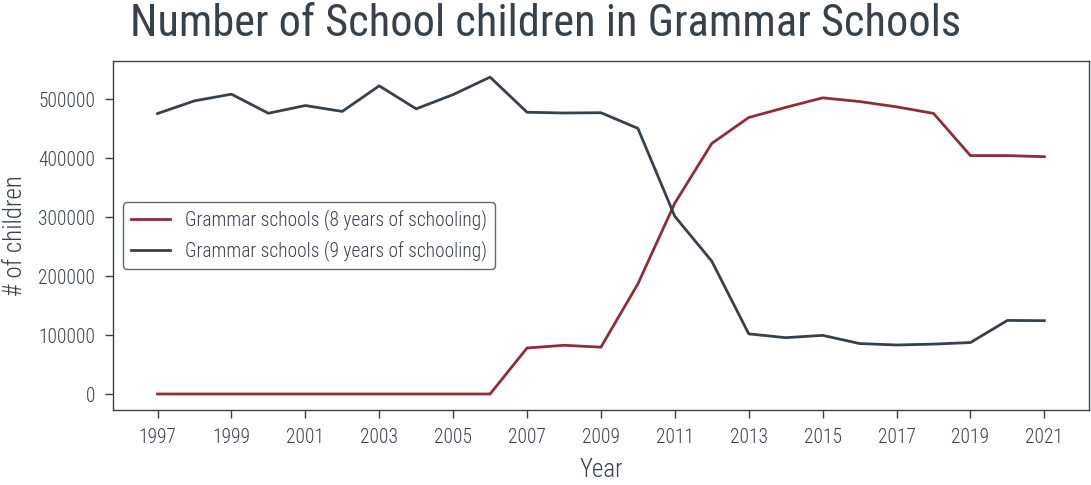

In [21]:
plot_data = pd.concat([
    data_school_type[data_school_type["School Type"] == "Grammar schools (9 years of schooling)"], 
    data_school_type[data_school_type["School Type"] == "Grammar schools (8 years of schooling)"], 
    ], ignore_index=True)
plot_data = plot_data.groupby(["School Type", "Gender", "Year"]).apply(lambda x: x["Value"].sum()).reset_index()
plot_data.rename(columns={0: "Value"}, inplace=True)

# Plot the data
fig, ax = plt.subplots(1, 1)

# Male, Female, Total
male = plot_data.loc[plot_data["Gender"] == "Male"]
female = plot_data.loc[plot_data["Gender"] == "Female"]
all = plot_data.loc[plot_data["Gender"] == "Total"]

# Plot
school_types = all["School Type"].unique() 
for t in school_types:
    ax.plot(all[all["School Type"] == t]["Year"], all[all["School Type"] == t]["Value"])

ax.set_xlabel("Year")
ax.set_ylabel("# of children")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))
ax.legend(school_types)

# Other settings
fig.suptitle("Number of School children in Grammar Schools", fontsize=16)

plt.show()

## Certificate Type

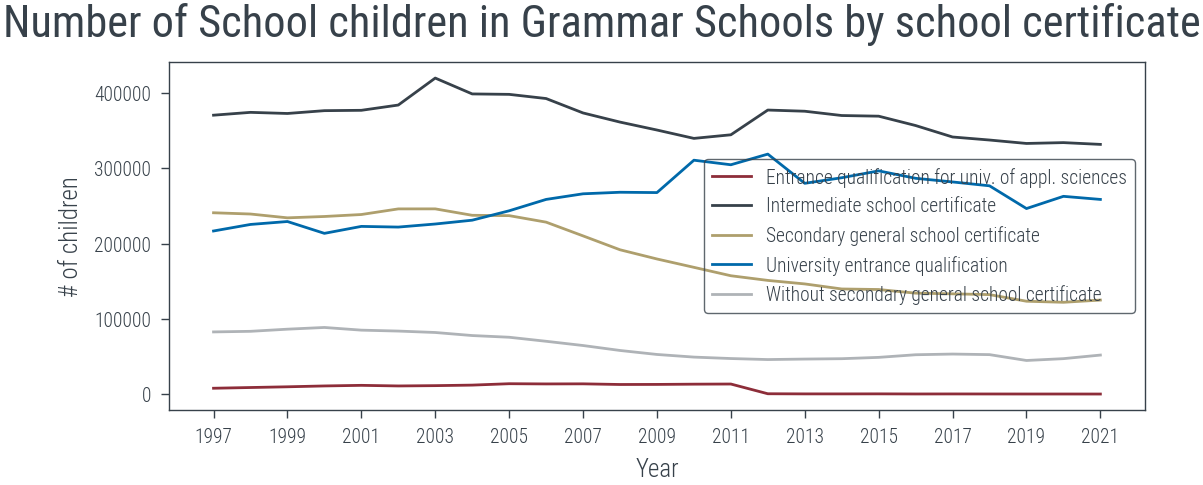

In [22]:
plot_data = data_school_type.copy()
plot_data = plot_data.groupby(["Certificate Type", "Gender", "Year"]).apply(lambda x: x["Value"].sum()).reset_index()
plot_data.rename(columns={0: "Value"}, inplace=True)

# Plot the data
fig, ax = plt.subplots(1, 1)

# Male, Female, Total
male = plot_data.loc[plot_data["Gender"] == "Male"]
female = plot_data.loc[plot_data["Gender"] == "Female"]
all = plot_data.loc[plot_data["Gender"] == "Total"]

# Plot
cert_types = all[all["Certificate Type"] != "Total"]["Certificate Type"].unique()
for t in cert_types:
    ax.plot(all[all["Certificate Type"] == t]["Year"], all[all["Certificate Type"] == t]["Value"])

ax.set_xlabel("Year")
ax.set_ylabel("# of children")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))
ax.legend(cert_types)

# Other settings
fig.suptitle("Number of School children in Grammar Schools by school certificate", fontsize=16)

plt.show()